# Imports

In [7]:
# read files
import json
import urllib.request 
import re, os
import sys
import pickle

# preprocessing, math
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk import ngrams
from sklearn.model_selection import train_test_split

# multiprocessing
from multiprocessing import Pool
from functools import partial

# helper functions
from helperFunctions import *

# naive bayes implementation
from naiveBayes import *

# evaluation
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
from sklearn.utils import class_weight

# Load dataset

In [8]:
# Source: https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset
dataset = 'True.csv' # Fake.csv
pathToDataFiles = './datafiles/'
df = pd.read_csv('dataset/' + dataset)

In [9]:
# Merge all textual input, discard the rest (except for the labels)
df.text = df.title + ' ' + df.text
df.rename(columns={'subject': 'label'},
          inplace=True, errors='raise')
df.drop(['title', 'date'], axis=1, errors='ignore', inplace=True)

In [10]:
df.shape

(21417, 2)

# Analyse and Preprocess

missing labels?

In [11]:
df.isnull().sum()

text     0
label    0
dtype: int64

classes

In [12]:
df.label.unique()

array(['politicsNews', 'worldnews'], dtype=object)

is the dataset balanced?

(<AxesSubplot:>,
 politicsNews    11272
 worldnews       10145
 Name: label, dtype: int64)

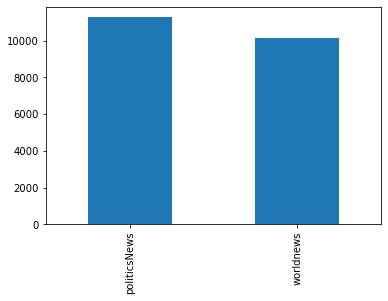

In [13]:
counts = df['label'].value_counts().sort_values(ascending=False)
counts.plot(kind='bar'), counts

Numeric Labels

In [14]:
le = LabelEncoder()
df.label = le.fit_transform(df.label)
df.head()

,text,label
0,"As U.S. budget fight looms, Republicans flip t...",0
1,U.S. military to accept transgender recruits o...,0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,0
3,FBI Russia probe helped by Australian diplomat...,0
4,Trump wants Postal Service to charge 'much mor...,0


Clean text, remove symbols and stopwords

In [15]:
# this needs alot of cpu AND ram resources
#df['text'] = df['text'].apply(preprocessNLFeature)
df.head()

,text,label
0,"As U.S. budget fight looms, Republicans flip t...",0
1,U.S. military to accept transgender recruits o...,0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,0
3,FBI Russia probe helped by Australian diplomat...,0
4,Trump wants Postal Service to charge 'much mor...,0


In [16]:
#df.to_csv('dataset_preprocessed-' + dataset, sep='\t', index=False)

In [17]:
# 10% of dataset because ngram is very time consuming
df = pd.read_csv('dataset_preprocessed-' + dataset, sep='\t') #.sample(frac=0.1, replace=False, random_state=12345)

Create train, validation, test split

In [18]:
# train val test relation -> 60:20:20
trainval, test = train_test_split(df, test_size=0.2, random_state=12345)
train, val = train_test_split(trainval, test_size=0.25, random_state=12345)
train.reset_index(drop=True, inplace=True)
val.reset_index(drop=True, inplace=True)
train.head()

,text,label
0,exclusive pentagon lockheed near deal billion ...,0
1,france says saudi coalition must boost aid eff...,1
2,u.s. renews call cambodia release opposition l...,1
3,treasury 's mnuchin trump 's proposed corporat...,0
4,romanian ruling party leader investigated 'cri...,1


prep validation set

In [19]:
y_val = val.label
val.drop('label', axis=1, inplace=True, errors='ignore')

# Naive Bayes with counting occurences

Create Frequency Table

In [14]:
# ~cubic complexity, very time consuming
#freq_tb_occ, uniques_occ = frequencyTableOccurences(train.text, train.label)

In [15]:
#np.save('freq_tb-occurences-' + dataset, freq_tb_occ)
#np.save('uniques-occurences-' + dataset, uniques_occ)

In [16]:
with open('freq_tb-occurences-' + dataset + '.npy', 'rb') as f:
    freq_tb_occ = np.load(f)
with open('uniques-occurences-' + dataset + '.npy', 'rb') as f:
    uniques_occ = np.load(f).tolist()

Create likelyhood table

In [17]:
# no need to merge all information into one table
sumRowsRel, sumColsRel = likelihoodTable(freq_tb_occ)  

## Apply Naive Bayes

run prediction for the validation set

In [18]:
""" y_pred = []
for d in val.text:
    y_pred.append(predictDoc(d.split(), uniques_occ, freq_tb_occ, sumRowsRel, sumColsRel)) """

' y_pred = []\nfor d in val.text:\n    y_pred.append(predictDoc(d.split(), uniques_occ, freq_tb_occ, sumRowsRel, sumColsRel)) '

In [19]:
""" df_results_occ = pd.DataFrame(val.text)
df_results_occ['label'] = y_val
df_results_occ['prediction'] = y_pred
df_results_occ['TPTN'] = df_results_occ.label == df_results_occ.prediction
df_results_occ.head() """

" df_results_occ = pd.DataFrame(val.text)\ndf_results_occ['label'] = y_val\ndf_results_occ['prediction'] = y_pred\ndf_results_occ['TPTN'] = df_results_occ.label == df_results_occ.prediction\ndf_results_occ.head() "

presist

In [20]:
#df_results_occ.to_csv('naive-bayes-occurences-results-' + dataset, sep='\t', index=False)
df_results_occ = pd.read_csv('naive-bayes-occurences-results-' + dataset, sep='\t')

# Naive Bayes with counting N-Grams

Create n-grams

In [21]:
# initial tests were made with n = 6, 
# but the chances of 6 words being repeated in the same order are very slim
# so I gradually reduced the size of the ngrams

n = 2
train['ngrams'] = train.text.apply(createNgrams, args=[n])

create frequency table

In [22]:
# ~down to quadratic complexity
#freq_tb_ng, uniques_ng = frequencyTableNgrams(train.ngrams, train.label)

In [23]:
""" np.save('freq_tb-N-Grams-' + str(n) + '-' + dataset, freq_tb_ng)
with open('uniques-N-Grams-' + str(n) + '-' + dataset + '.pkl', 'wb') as f:
    pickle.dump(uniques_ng, f) """

" np.save('freq_tb-N-Grams-' + str(n) + '-' + dataset, freq_tb_ng)\nwith open('uniques-N-Grams-' + str(n) + '-' + dataset + '.pkl', 'wb') as f:\n    pickle.dump(uniques_ng, f) "

In [24]:
with open('freq_tb-N-Grams-' + str(n) + '-' + dataset + '.npy', 'rb') as f:
    freq_tb_ng = np.load(f)
      
with open('uniques-N-Grams-' + str(n) + '-' + dataset + '.pkl', 'rb') as f:
    uniques_ng = pickle.load(f)

create likelihood table

In [25]:
# no need to merge all information into one table
sumRowsRel, sumColsRel = likelihoodTable(freq_tb_ng)  

## Apply Naive Bayes

Create n-grams in the validation set

In [26]:
val['ngrams'] = val.text.apply(createNgrams, args=[n])

run prediction for the validation set

In [29]:
y_pred = []
progress = 0
total = len(val.ngrams[:10])-1
for listOfNgrams in val.ngrams[:10]:
    print('predicting document', str(progress), 'of', str(total))
    progress += 1
    y_pred.append(predictDoc(listOfNgrams, uniques_ng, freq_tb_ng, sumRowsRel, sumColsRel, nclasses=2))

predicting document 0 of 9
predicting document 1 of 9
predicting document 2 of 9
predicting document 3 of 9
predicting document 4 of 9
predicting document 5 of 9
predicting document 6 of 9
predicting document 7 of 9
predicting document 8 of 9
predicting document 9 of 9


In [33]:
with Pool(16) as p:
    y_p = p.map(partial(predictDoc, uniques=uniques_ng, freq_tb= freq_tb_ng, sumRowsRel=sumRowsRel, sumColsRel=sumColsRel, nclasses=2) , val.ngrams)

In [32]:
y_p

[0, 1, 0, 1, 1, 0, 0, 1, 0, 0]

In [ ]:
df_results_ng = pd.DataFrame(val.ngrams)
df_results_ng['label'] = y_val
df_results_ng['prediction'] = y_pred
df_results_ng['TPTN'] = df_results_ng.label == df_results_ng.prediction
df_results_ng.head()

,ngrams,label,prediction,TPTN
0,"[(yemen, humanitarian), (humanitarian, situati...",1,0,False
1,"[(erdogan, says), (says, turkey), (turkey, ira...",1,1,True
2,"[(republican, ryan), (ryan, raising), (raising...",0,0,True
3,"[(mexican, president), (president, asks), (ask...",1,1,True
4,"[(uk, government), (government, official), (of...",1,1,True


persist

In [20]:
n = 2
df_results_ng = pd.read_csv(pathToDataFiles + 'naive-bayes-N-Grams-' + str(n) + '-results-' + dataset, sep='\t')

# Evaluate prediction

In [21]:
# use weighted accuracy, since the dataset is unbalanced
val_sample_weights = class_weight.compute_sample_weight('balanced', train.label._values)

Normal Accuracy

In [23]:
df_results_occ = pd.read_csv(pathToDataFiles + 'naive-bayes-occurences-results-' + dataset, sep='\t')
df_results_ng = pd.read_csv(pathToDataFiles + 'naive-bayes-N-Grams-' + str(n) + '-results-' + dataset, sep='\t')
df_results_ng.prediction.value_counts()

0    2775
1    1734
Name: prediction, dtype: int64

In [24]:
counts = pd.Series(df_results_occ.label == 0).value_counts() # always guess the most common class
acc = counts[1]/counts.sum()    # (TP + TN) / ALL
print('baseline accuracy of always predicting the most common class:', acc)

counts = df_results_occ.TPTN.value_counts()
acc = counts[1]/counts.sum()
print('accuracy for NB with occurences count:', acc)

counts = df_results_ng.TPTN.value_counts()
acc = counts[1]/counts.sum()
print('accuracy for NB with N-Grams of ' + str(n) + ' count:', acc)

baseline accuracy of always predicting the most common class: 0.5092038145930361
accuracy for NB with occurences count: 0.8298957640275005
accuracy for NB with N-Grams of 2 count: 0.8582834331337326


Weighted Accuracy

In [29]:
from sklearn.metrics import balanced_accuracy_score

# baseline, just guess one class all the time
baseline_weighted_accuracy = balanced_accuracy_score(y_val, [0 for l in y_val])

# Naive Bayes with count of word occurences
occ_weighted_accuracy = balanced_accuracy_score(df_results_occ.label, df_results_occ.prediction)                                           

# Naive Bayes with N-grams
ng_weighted_accuracy = balanced_accuracy_score(df_results_ng.label, df_results_ng.prediction)


print('baseline_weighted_accuracy=%.3f' %baseline_weighted_accuracy)
print('NB with word occurences weighted accuracy=%.3f' %occ_weighted_accuracy)
print('NB with N-Grams of ' + str(n) + ' weighted accuracy=%.3f' %ng_weighted_accuracy)

baseline_weighted_accuracy=0.500
NB with word occurences weighted accuracy=0.831
NB with N-Grams of 2 weighted accuracy=0.856


# Naive Bayes with TF-IDF

In [ ]:
vectorizer = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 6000)

In [ ]:
feature_vec = vectorizer.fit_transform(train.text)

In [ ]:
tf_transformer = TfidfTransformer(use_idf=True).fit(feature_vec)
X_train_tf = tf_transformer.transform(feature_vec)
X_train_tf.shape

## TODO: Adjust to own version

In [ ]:

# create train/test set
train_data = train_text
train_labels = train["author"]
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(train_data,train_labels,test_size=0.20,random_state=0)

In [ ]:
from sklearn.pipeline import Pipeline

text_features = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
])

text_features.fit_transform(X_train)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, log_loss

pipe = Pipeline([
    ('features', text_features),
    ('clf', MultinomialNB()),
])

pipe.fit(X_train, y_train)

nb_pred = pipe.predict(X_test)
nb_probs = pipe.predict_proba(X_test)

print("Accuracy score: " + str(accuracy_score(y_test, nb_pred)))
print("Log loss: " + str(log_loss(y_test, nb_probs)));